In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

In [11]:
# check submission format for Round 1 
sample_pred = pd.read_csv('data/MSampleSubmissionStage1_2020.csv')
display(sample_pred.head())
print(len(sample_pred))

,ID,Pred
0,2015_1107_1112,0.5
1,2015_1107_1116,0.5
2,2015_1107_1124,0.5
3,2015_1107_1125,0.5
4,2015_1107_1129,0.5


11390


### Generate Labels

In [86]:
compact_results = pd.read_csv('data/MDataFiles_Stage1/MNCAATourneyCompactResults.csv')
compact_results.info()
compact_results.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2251 entries, 0 to 2250
Data columns (total 8 columns):
Season     2251 non-null int64
DayNum     2251 non-null int64
WTeamID    2251 non-null int64
WScore     2251 non-null int64
LTeamID    2251 non-null int64
LScore     2251 non-null int64
WLoc       2251 non-null object
NumOT      2251 non-null int64
dtypes: int64(7), object(1)
memory usage: 140.8+ KB


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [88]:
# generate game ID and label 
compact_results = compact_results.assign(
    TeamA = lambda x: x[['WTeamID','LTeamID']].min(axis=1), 
    TeamB = lambda x: x[['WTeamID','LTeamID']].max(axis=1), 
    ID = lambda x: x['Season'].astype(str) + '_' + x['TeamA'].astype(str) + '_' + x['TeamB'].astype(str),
    Outcome = lambda x: np.where(x['WTeamID'] < x['LTeamID'], 1, 0)
)
compact_results.info()
display(compact_results.head())
compact_results['Outcome'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2251 entries, 0 to 2250
Data columns (total 12 columns):
Season     2251 non-null int64
DayNum     2251 non-null int64
WTeamID    2251 non-null int64
WScore     2251 non-null int64
LTeamID    2251 non-null int64
LScore     2251 non-null int64
WLoc       2251 non-null object
NumOT      2251 non-null int64
TeamA      2251 non-null int64
TeamB      2251 non-null int64
ID         2251 non-null object
Outcome    2251 non-null int64
dtypes: int64(10), object(2)
memory usage: 211.1+ KB


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,TeamA,TeamB,ID,Outcome
0,1985,136,1116,63,1234,54,N,0,1116,1234,1985_1116_1234,1
1,1985,136,1120,59,1345,58,N,0,1120,1345,1985_1120_1345,1
2,1985,136,1207,68,1250,43,N,0,1207,1250,1985_1207_1250,1
3,1985,136,1229,58,1425,55,N,0,1229,1425,1985_1229_1425,1
4,1985,136,1242,49,1325,38,N,0,1242,1325,1985_1242_1325,1


1    1137
0    1114
Name: Outcome, dtype: int64

### Parse Seeds 

In [89]:
seeds = pd.read_csv('data/MDataFiles_Stage1/MNCAATourneySeeds.csv')
display(seeds.head())
len(seeds)

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


2286

In [90]:
seeds['SeedNum'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds['SeedNum'].value_counts().sort_index()

1     140
2     140
3     140
4     140
5     140
6     140
7     140
8     140
9     140
10    140
11    153
12    143
13    141
14    141
15    140
16    168
Name: SeedNum, dtype: int64

In [91]:
seeds = seeds.set_index(['Season','TeamID'])['SeedNum']

### Baseline Model: Logistic Regression w/ SeedDiff Only

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [76]:
df = compact_results.merge(seeds, how='left', left_on=['Season', 'TeamA'], right_index=True)\
                    .merge(seeds, how='left', left_on=['Season', 'TeamB'], right_index=True, suffixes=('_A', '_B'))
df['SeedDiff'] = df['SeedNum_B'] - df['SeedNum_A'] 

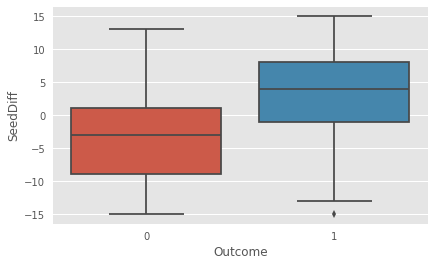

In [102]:
sns.boxplot(x='Outcome', y='SeedDiff', data=df);

In [112]:
# train/test split: train on seasons through 2016, validate on seasons 2017-19 
train = df.query("Season < 2017")
val = df.query("Season >= 2017")
print("Train: {} | Val: {}".format(len(train), len(val)))

Train: 2050 | Val: 201


In [115]:
lr_seeddiff = LogisticRegression()
lr_seeddiff.fit(train[['SeedDiff']], train['Outcome'])
lr_preds = lr_seeddiff.predict_proba(val[['SeedDiff']])
log_loss(val['Outcome'], lr_preds)

0.5577789914274504